In [17]:
import pandas as pd
import spacy
import gensim
import numpy as np
import string, re
from collections import Counter
import pickle

from tqdm import tqdm

import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.probability import FreqDist

import sklearn
import sklearn.neural_network
import sklearn.cluster
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.manifold import TSNE

import tensorflow
import tensorflow.keras.models
from tensorflow.keras.models import Sequential, load_model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalMaxPooling1D, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from gensim.models import KeyedVectors, LdaModel
from gensim.models.coherencemodel import CoherenceModel

import lucem_illud
import matplotlib.pyplot as plt
import matplotlib.cm #Still for graphics
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap as LSC
import wordcloud 

import warnings
from collections import defaultdict
from scipy.spatial.distance import cosine

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
# let's create some additional stop words
stop_words = set(stopwords.words('english'))
# add more stop words
custom_stopwords = set(["could've", "would've", "r", "u/", "u", "/r" "r/", "t", 've', 's', 'm', 
                        'll', 'd', 're', 'n', 'y', 'b', 'p', 'f', 'c', 'e', 'g', 
                        'h', 'j', 'k', 'l', 'o', 'q', 'v', 'w', 'x', 'z', 'a', 'i', "gt", "amp",
                        'br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 
                        'ours', 'ourselves', 'you', "you're", "you've","you'll", 
                        "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 
                        'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 
                        'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 
                        'their', 'theirs', 'themselves', 'what', 'these', 'those',
                        'which', 'who', 'whom', 'this', 'that', "that'll",  
                        'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 
                        'have', 'has', 'had', 'having', 'do', 'does', 
                        'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 
                        'or', 'because', 'as', 'until', 'while', 'of', 
                        'at', 'by', 'for', 'with', 'about', 'against', 'between', 
                        'into', 'through', 'during', 'before', 'after',
                        'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 
                        'on', 'off', 'over', 'under', 'again', 'further',
                        'then', 'once', 'here', 'there', 'when', 'where', 'why', 
                        'how', 'all', 'any', 'both', 'each', 'few', 'more',
                        'most', 'other', 'some', 'such', 'only', 'own', 'same', 
                        'so', 'than', 'too', 'very', 
                        's', 't', 'can', 'will', 'just', 'don', "don't", 'should', 
                        "should've", 'now', 'd', 'll', 'm', 'o', 're', 
                        've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 
                        'didn', "didn't", 'doesn', "doesn't", 'hadn',
                        "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', 
                        "isn't", 'ma', 'mightn', "mightn't", 'mustn',
                        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', 
                        "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 
                        'won', "won't", 'wouldn', "wouldn't"])

stop_words.update(custom_stopwords)
stop_words = list(stop_words)
# create custom color map for graphs
colors = ['#800000', '#D9D9D9', '#A6A6A6', '#737373']
cmap = LSC.from_list("custom_colormap", colors)

## Helpers

In [3]:
def plot_freqs(data, n=50, freq=True, title='    Word Frequency\n'):
    """
    Plot two bar plots side by side.
    Inputs:
        data (dict of pd.Series or FreqDist): Maps a str regarding the source of data 
            to a pandas series or FreqDist containing the strs for the corresponding words
        n (int): Number of words (default=50).
        freq (bool): Whether to plot the frequency or the count (default=True).
        title (str): Title for the entire figure 
            (default='    Normalized Token Frequency\n').

    Return None, plots word counts/frequency charts side by side
    """
    # figure out the dimensions of the subplots
    fig, axs = plt.subplots(2, 1, figsize=(n**.5 * 16 / 10, 9))

    # create a title for the entire plot
    fig.suptitle(title, fontsize=24, ha='center') # title for entire plot

    # plot every source and word column 
    for i, (source, structure) in enumerate(data.items()):
        
        # check if the structure is a pandas series
        if type(structure) == pd.core.series.Series:
            freqs = FreqDist(structure.explode())
        # get the top most common words
            top_n = pd.DataFrame(freqs.most_common(n), 
                                 columns=["word", "freq"])
        # check if FreqDist
        elif type(structure) == nltk.probability.FreqDist:
            top_n = pd.DataFrame(structure.most_common(n), 
                                 columns=["word", "freq"])
        # if the word_col is not a pandas series or nltk FreqDist, raise an error
        else:
            raise ValueError("word_col must be a pandas series or a nltk FreqDist")

        # if freq is true, plot the frequency, otherwise plot the count
        if freq: # Calculate total count
            total_count = top_n['freq'].sum()
            # Calculate percents
            top_n['percent'] = (top_n['freq'] / total_count) * 100
            # plot the the top n words
            y_data = top_n.percent
            y_label = 'Frequency (%)'
        else:
            y_data = top_n.freq
            y_label = "Counts"

        axs[i].plot(top_n.word, y_data, color='#800000', marker="o")

        # labeling axes and ticks
        axs[i].set_ylabel(y_label, fontsize=16)
        # set x ticks
        axs[i].set_xticks(top_n.word)
        axs[i].set_xticklabels(top_n.word, rotation=45, ha='right', fontsize=12)
        axs[i].set_xlabel(source, fontsize=16, ha='center')
        axs[i].xaxis.set_label_position('top')
    # plot side by side
    plt.tight_layout()
    plt.show()
    return


def plot_comp_bars(sources, n=50):
    """
    Plot a bar chart comparing shared words from the top n words from 2 sources
    Inputs:
        sources (dict of FreqDist): Maps a str regarding the source of data 
            to FreqDist of the word counts for the corresponding words
        n (int): Number of words (default=50).
        title (str): Title for the plot (default='').

    Return a DF with frequencies (%) for each word matching both sources, 
        plots word counts/frequency bar chart comparing sources
    """
    values = list(sources.values())
    keys = list(sources.keys())
    if type(values[0]) == nltk.probability.FreqDist:
        word_freq_1 = values[0]
    elif type(values[0]) == pd.core.series.Series:
        word_freq_1 = FreqDist(values[0].explode())        
    else:
        raise ValueError("word_col must be a nltk FreqDist")

    if type(values[1]) == nltk.probability.FreqDist:
        word_freq_2 = values[1]
    elif type(values[1]) == pd.core.series.Series:
        word_freq_2 = FreqDist(values[1].explode())        
    else:
        raise ValueError("Data in source Dict must be an nltk FreqDist or a pandas Series")

    max_iters = min(len(word_freq_1), len(word_freq_2))
    if n > max_iters:
        warning = f"n = {n} is greater than the length of the FreqDist ({max_iters}), setting n to {max_iters} instead"
        warnings.warn(warning)
        n = max_iters
    i = n
    # iterate until we reach n matches or stop at smaller of the FreqDist lengths
    while True:
        
        # Get the top most common words
        top_n_1 = pd.DataFrame(word_freq_1.most_common(i), 
                               columns=["word","freq"])
        top_n_2 = pd.DataFrame(word_freq_2.most_common(i), 
                               columns=["word","freq"])
        
        # because we are comparing distr, we should get percentages
        top_n_1["percent"] = (top_n_1['freq'] / top_n_1['freq'].sum()) * 100
        top_n_2["percent"] = (top_n_2['freq'] / top_n_2['freq'].sum()) * 100

        # Merge the social media and news counts into one df and get the percentages
        all_top_n = pd.merge(top_n_1.groupby('word').sum(), 
                            top_n_2.groupby('word').sum(), 
                            on='word').drop(columns=['freq_x', 'freq_y'], 
                                            axis=1).reset_index()
        # if we fail to reach n matches, we should increment i
        len_all_top_n = len(all_top_n)
        if len_all_top_n < n and i <= max_iters:
            i += 1
        else:
            # should remind user if did not reach n matches
            if len_all_top_n < n:
                warning = f"Did not reach {n} matches, plotted all {len(all_top_n)} possible matches"
                n = len(all_top_n)
                warnings.warn(warning)
            
            # rename columns to be more informative
            all_top_n = all_top_n.rename(columns={'percent_x': f'{keys[0]}',
                                                  "percent_y": f'{keys[1]}'})
            
            # sort the values by the first source
            all_top_n_sorted = all_top_n.sort_values(by=f'{keys[0]}', 
                                                     ascending=False)
            # plot the bar graph
            ax = all_top_n_sorted.plot(kind='bar', x='word',
                                       # set the figsize based off of n sorta :)
                                       figsize=(n**.5 * 16 / 5, 9), 
                                       color=colors[0::3],
                                       width=.75)
            # set labels
            ax.set_title(f"Top {n} Words in {keys[0]} and {keys[1]}", fontsize=18)
            ax.set_xticklabels(all_top_n_sorted.word, rotation=45, ha='right', 
                               fontsize=12)
            ax.set_xlabel("")
            ax.set_ylabel('Frequency (%)', fontsize=14)
            plt.show()
            return all_top_n_sorted
        

def make_word_cloud(data, max_words=100, title=""):
    """
    Create a WordCloud object with specified parameters and plot it
    Inputs:
        data: (str) a string of data to be used for the word cloud
        max_words: (int) maximum number of words to display (default=100)
        title: (str) title for the plot (default="")
    Returns None, plots a word cloud
    """
    wc = wordcloud.WordCloud(background_color="white", max_words=max_words, 
                             width=1000, colormap=cmap,height=1000, 
                             mode='RGBA', scale=.5)
    
    if type(data) == pd.core.series.Series:
        wc = wc.generate(" ".join(data))
    elif type(data) == nltk.probability.FreqDist:
        wc = wc.generate_from_frequencies(data)
    else:
        raise ValueError("Data must be an pandas Series or a nltk FreqDist")
    plt.figure(figsize=(6, 6))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(title)
    plt.show()
    return


# for model eval

def mod_eval(clf, X_test, y_test):
    """
    Given a classifier and data print out a classification report and 
    a corresponding ROC-AUC chart to visualize model performance.

    Inputs:
        clf: an sklearn classifier 
        X_test: an array like structure of model testing features 
        y_test: an array like structure of model testing y's
    Return nothing, prints classification report table and plots a ROC-AUC curve
    """
    # find yhats for testing data
    y_pred_test = clf.predict(X_test)
    # model performance on testing set
    print(classification_report(y_test, y_pred_test),"\n")
    
    con_mat = confusion_matrix(y_test, y_pred_test)
    # help displaying a confusion matrix with labels
    # https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
    labels = ['Non-adoptees', 'Adoptees']
    cmd = ConfusionMatrixDisplay(con_mat, display_labels=labels)
    cmd.plot(cmap="crest")


def vect_and_split(vectorizer, feature_col, y_col):
    """
    Vectorizers a column of text data features, and performs a test-train split
    Inputs:
        vectorizer: the vectorizer to vectorize the feature column
        feature_col: the column of textual data that will act as the features
        y_col: the column containing the y's
    Outputs:
        train and test split for X and y's
    """

    # convert the cleaned reviews to vectors
    X = vectorizer.fit_transform(feature_col)
    return train_test_split(X, y_col, test_size=0.2, shuffle=True, random_state=42)

## word2vec models

#### create models

In [4]:
all_df = pd.read_pickle("D:\\hw\\adopt-proj\\newest_all_df.pkl")

# some comments are very short so we will get rid of those as they are more 
# likely to be noisy
all_df = all_df[all_df.num_tokens > 25]

create models for adoptee and non adoptee

In [6]:
# create models for adoptee and non adoptee
adoptee_model = gensim.models.word2vec.Word2Vec(all_df[
    all_df.is_adoptee == 1].norm_sents.explode().dropna().reset_index(drop=True))
non_adoptee_model = gensim.models.word2vec.Word2Vec(all_df[
    all_df.is_adoptee == 0].norm_sents.explode().dropna().reset_index(drop=True))
adoptee_model.save("NEW_adoptee_word2vec.model")
non_adoptee_model.save("NEW_non_adoptee_word2vec.model")

In [7]:
# create full model for all data and data for each subreddit
all_adopt_model = gensim.models.word2vec.Word2Vec(all_df[all_df.subreddit == 
        "r/Adoption"].norm_sents.explode().dropna().reset_index(drop=True))
r_adopted_model = gensim.models.word2vec.Word2Vec(all_df[all_df.subreddit == 
        "r/Adopted"].norm_sents.explode().dropna().reset_index(drop=True))
r_adoption_model = gensim.models.word2vec.Word2Vec(
    all_df.norm_sents.explode().dropna().reset_index(drop=True))

all_adopt_model.save("NEW_all_adopt_word2vec.model")
r_adopted_model.save("NEW_r_adopted_word2vec.model")
r_adoption_model.save("NEW_r_adoption_word2vec.model")

Create word embeddings for adoptees in r/Adoption and r/Adopted

In [169]:
r_adoption_adoptees_model = gensim.models.word2vec.Word2Vec(all_df[(all_df.subreddit == "r/Adoption") & (all_df.is_adoptee == 1)].norm_sents.explode().dropna().reset_index(drop=True))
r_adopted_adoptees_model = gensim.models.word2vec.Word2Vec(all_df[(all_df.subreddit == "r/Adopted") & (all_df.is_adoptee == 1)].norm_sents.explode().dropna().reset_index(drop=True))
r_adoption_adoptees_model.save("r_adoption_adoptees_word2vec.model")
r_adopted_adoptees_model.save("r_adopted_adoptees_model_word2vec.model")

## load data and models

In [4]:
all_df = pd.read_pickle("D:\\hw\\adopt-proj\\newest_all_df.pkl")

# some comments are very short so we will get rid of those as they are more 
# likely to be noisy
all_df = all_df[all_df.num_tokens > 25]

Get only the labeled data

In [5]:
labeled_df = all_df[(all_df.is_adoptee < 2)]
unlabeled_df = all_df[(all_df.is_adoptee == 2)]
labeled_labels = labeled_df.is_adoptee

Load the models

In [7]:
all_adopt_word2vec = gensim.models.Word2Vec.load("D:\\hw\\adopt-proj\\NEW_all_adopt_word2vec.model")
r_adopted_model = gensim.models.Word2Vec.load("D:\\hw\\adopt-proj\\NEW_r_adopted_word2vec.model")
r_adoption_model = gensim.models.Word2Vec.load("D:\\hw\\adopt-proj\\NEW_r_adoption_word2vec.model")
adoptee_model = gensim.models.Word2Vec.load("D:\\hw\\adopt-proj\\NEW_adoptee_word2vec.model")
non_adoptee_model = gensim.models.Word2Vec.load("D:\\hw\\adopt-proj\\NEW_non_adoptee_word2vec.model")
r_adoption_adoptees_model = gensim.models.Word2Vec.load("D:\\hw\\adopt-proj\\r_adoption_adoptees_word2vec.model")
r_adopted_adoptees_model = gensim.models.Word2Vec.load("D:\\hw\\adopt-proj\\r_adopted_adoptees_model_word2vec.model")

Define the vectorizer

In [8]:
tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words=stop_words, 
                                   max_df=0.9, min_df=3, ngram_range=(1,2))

Find the training testing split

In [9]:
X_train, X_test, y_train, y_test = vect_and_split(tfidf_vectorizer,
                                                  labeled_df.cleaner_text, 
                                                  labeled_df.is_adoptee)

c:\Users\Ethan\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'rr', 'would'] not in stop_words.
  warnings.warn(


## Neural Networks

#### Vectorizing

In [10]:
# Define model architecture
max_length = 6000
max_tokens = 20000
vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="tf_idf", # try "int", "count", "multi_hot", "tf_idf"
    # output_sequence_length=max_length,
)

# need to be in random order for train, test, val split
shuffled_df = labeled_df.sample(frac=1).reset_index(drop=True)
vectorizer.adapt(shuffled_df['cleaner_text'])
vectorized_text = vectorizer(shuffled_df['cleaner_text'])
# get the vocabulary
vocab = vectorizer.get_vocabulary()

#### Train, Test, Validation Splitting

In [11]:
end_train = round(len(vectorized_text) * .6)
end_test = end_train + round(len(vectorized_text) * .2)

In [12]:
X_train1 = vectorized_text[:end_train]
X_test1 = vectorized_text[end_train:end_test]
X_val1 = vectorized_text[end_test:]

y_train1 = shuffled_df.is_adoptee[:end_train]
y_test1 = shuffled_df.is_adoptee[end_train:end_test]
y_val1 = shuffled_df.is_adoptee[end_test:]

#### Model building

In [15]:
# create the model
ds_model = tensorflow.keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
# compile the model
ds_model.compile(optimizer="rmsprop",
                 loss="binary_crossentropy",
                 metrics=["accuracy"])

ds_history = ds_model.fit(X_train1, y_train1, epochs=20, batch_size=512,
                          validation_data=(X_val1, y_val1))


Epoch 1/20

29/29 [==============================] - 3s 56ms/step - loss: 0.5591 - accuracy: 0.7165 - val_loss: 0.4791 - val_accuracy: 0.7761
Epoch 2/20
29/29 [==============================] - 0s 16ms/step - loss: 0.3607 - accuracy: 0.8559 - val_loss: 0.5262 - val_accuracy: 0.7531
Epoch 3/20
29/29 [==============================] - 1s 18ms/step - loss: 0.2601 - accuracy: 0.9050 - val_loss: 0.4612 - val_accuracy: 0.7841
Epoch 4/20
29/29 [==============================] - 0s 16ms/step - loss: 0.1937 - accuracy: 0.9341 - val_loss: 0.4815 - val_accuracy: 0.7850
Epoch 5/20
29/29 [==============================] - 0s 16ms/step - loss: 0.1435 - accuracy: 0.9565 - val_loss: 0.5164 - val_accuracy: 0.7784
Epoch 6/20
29/29 [==============================] - 0s 16ms/step - loss: 0.1045 - accuracy: 0.9717 - val_loss: 0.5855 - val_accuracy: 0.7685
Epoch 7/20
29/29 [==============================] - 0s 16ms/step - loss: 0.0773 - accuracy: 0.9812 - val_loss: 0.6331 - val_accuracy: 0.7681
Epoch 8/20


#### Validation

In [21]:
# evaluate model performance regarding accuracy
test_loss, test_acc = ds_model.evaluate(X_test1, y_test1)
print(f"test_acc: {np.round(test_acc,3)}")

152/152 [==============================] - 0s 2ms/step - loss: 1.4255 - accuracy: 0.7563
test_acc: 0.756


In [22]:
# print other evaluation metrics
predict_probs = ds_model.predict(X_test1)
y_pred1 = (predict_probs > 0.8).astype(int)
print(classification_report(y_test1, y_pred1))

152/152 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.68      0.76      0.72      2010
           1       0.82      0.75      0.78      2853

    accuracy                           0.76      4863
   macro avg       0.75      0.76      0.75      4863
weighted avg       0.76      0.76      0.76      4863



#### Save model

In [23]:
ds_model.save("tf_idf_dense_nn.keras")


with open('tf_idf_dense_nn_history.pkl', 'wb') as f:
    pickle.dump(ds_history, f)

open

In [24]:
ds_model = load_model("tf_idf_dense_nn.keras")

with open('tf_idf_dense_nn_history.pkl', 'rb') as file_pi:
    ds_history = pickle.load(file_pi)

#### viz

Creating a function to visualize the NN performance over epoch

In [25]:
def visualize_performance(history, flag):
    """
    Help visualize the NN performance
    """
    history_dict = history.history
    epochs = range(1, len(history_dict["loss"]) + 1)

    plt.plot(epochs, history_dict[flag], "bo", label="Training "+flag)
    plt.plot(epochs, history_dict["val_"+flag], "b", label="Validation "+flag)
    plt.title("Training and validation "+flag)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

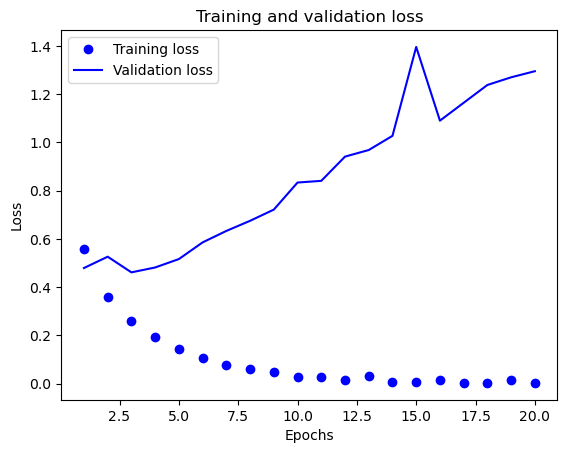

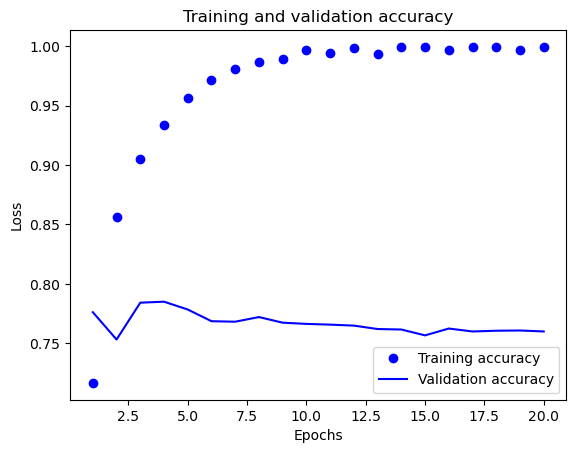

In [26]:
visualize_performance(ds_history, flag = 'loss')
visualize_performance(ds_history, flag = 'accuracy')

We see some overfitting, particularly after the 3rd epoch, the validation accuracy starts leveling off and slightly decreasing

### Bidrectional LSTM

#### Vectorizing

In [27]:
max_length = 600
max_tokens = 20000
vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
vectorizer.adapt(shuffled_df['cleaner_text'])
bi_lstm_vectorized_text = vectorizer(shuffled_df['cleaner_text'])

#### Train, Test, Validation splits

In [28]:
X_train2 = bi_lstm_vectorized_text[:end_train]
X_test2 = bi_lstm_vectorized_text[end_train:end_test]
X_val2 = bi_lstm_vectorized_text[end_test:]

# y_train1 = shuffled_df.is_adoptee[:end_train]
# y_test1 = shuffled_df.is_adoptee[end_train:end_test]
# y_val1 = shuffled_df.is_adoptee[end_test:]

#### Model building

In [29]:
# create the embedding layer
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs) # try mask_zero=True

# build a bidirectional LSTM
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

eb_model = keras.Model(inputs, outputs)
eb_model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
eb_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 bidirectional (Bidirection  (None, 64)                73984     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5194049 (19.81 MB)
Trainable params: 5194049 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [30]:
# train the model
eb_history = eb_model.fit(X_train2, y_train1, epochs=20, batch_size=512,
                          validation_data=(X_val2, y_val1))

Epoch 1/20


29/29 [==============================] - 62s 2s/step - loss: 0.6766 - accuracy: 0.5905 - val_loss: 0.6765 - val_accuracy: 0.5833
Epoch 2/20
29/29 [==============================] - 61s 2s/step - loss: 0.6629 - accuracy: 0.6011 - val_loss: 0.6244 - val_accuracy: 0.6544
Epoch 3/20
29/29 [==============================] - 64s 2s/step - loss: 0.6168 - accuracy: 0.6635 - val_loss: 0.6022 - val_accuracy: 0.6949
Epoch 4/20
29/29 [==============================] - 64s 2s/step - loss: 0.5688 - accuracy: 0.7120 - val_loss: 0.5535 - val_accuracy: 0.7286
Epoch 5/20
29/29 [==============================] - 63s 2s/step - loss: 0.5372 - accuracy: 0.7373 - val_loss: 0.5520 - val_accuracy: 0.7146
Epoch 6/20
29/29 [==============================] - 65s 2s/step - loss: 0.5081 - accuracy: 0.7600 - val_loss: 0.5794 - val_accuracy: 0.6780
Epoch 7/20
29/29 [==============================] - 65s 2s/step - loss: 0.4916 - accuracy: 0.7730 - val_loss: 0.5574 - val_accuracy: 0.7447
Epoch 8/20
29/29 [=============

In [31]:
# evaluate model performance regarding accuracy
test_loss, test_acc = eb_model.evaluate(X_test2, y_test1)
print(f"test_acc: {np.round(test_acc,3)}")

152/152 [==============================] - 9s 58ms/step - loss: 0.5091 - accuracy: 0.7687
test_acc: 0.769


In [32]:
# print other evaluation metrics
predict_probs = eb_model.predict(X_test2)
y_pred2 = (predict_probs > 0.8).astype(int)
print(classification_report(y_test1, y_pred2))

152/152 [==============================] - 9s 57ms/step
              precision    recall  f1-score   support

           0       0.63      0.87      0.73      2010
           1       0.88      0.64      0.74      2853

    accuracy                           0.74      4863
   macro avg       0.75      0.76      0.74      4863
weighted avg       0.78      0.74      0.74      4863



#### save model

In [33]:
eb_model.save('biLSTM_nn.keras')

with open('biLSTM_nn_history.pkl', 'wb') as f:
    pickle.dump(eb_history, f)

open

In [35]:
eb_model = load_model('biLSTM_nn.keras')

with open('biLSTM_nn_history.pkl', 'rb') as f:
    eb_history = pickle.load(f)

#### viz

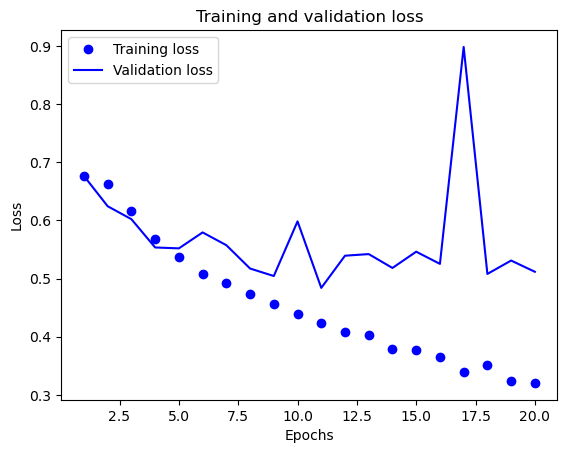

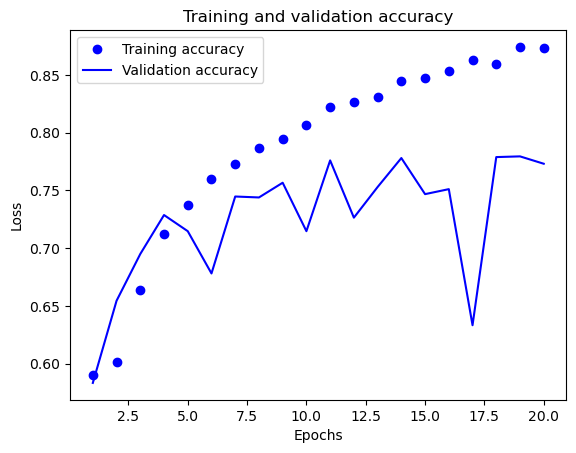

In [36]:
visualize_performance(eb_history, flag = 'loss')
visualize_performance(eb_history, flag = 'accuracy')

Overall, with the neural network we see only small improvements in the training accuracy as we increase over time, but we see that the validation accuracy remains low for the BERT transformer.

### MLP Classifier

In [462]:
clf_MLP = sklearn.neural_network.MLPClassifier(random_state=42)
clf_MLP.fit(X_train, y_train)

MLPClassifier(random_state=42)

In [463]:
pickle.dump(clf_MLP, open("clf_MLP.pkl", "wb"))

# load back in 
clf_MLP = pickle.load(open("D:\\hw\\adopt-proj\\clf_MLP.pkl", "rb"))

              precision    recall  f1-score   support

           0       0.74      0.69      0.71      2039
           1       0.79      0.82      0.80      2824

    accuracy                           0.77      4863
   macro avg       0.76      0.76      0.76      4863
weighted avg       0.76      0.77      0.76      4863
 



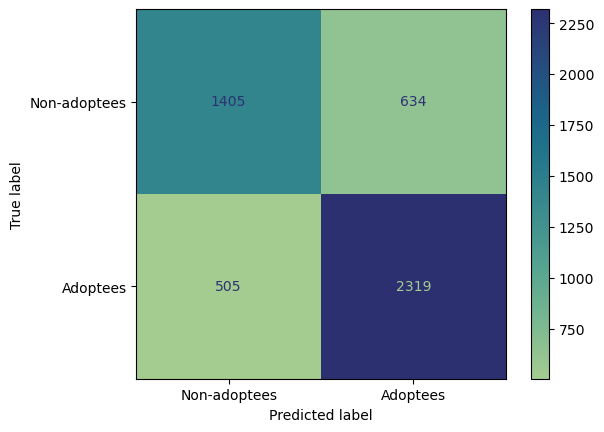

In [464]:
mod_eval(clf_MLP, X_test, y_test)

## Word Embeddings

In [11]:
def graph_embeddings(model1, model2, labels=["0","1"]):
    """
    Using word embedding models find the t-SNE embeddings and plot them, using labels
    Inputs:
        model1: word2vec model 1
        model2: word2vec model 2
        labels: list of labels for the models, defaults to 0 and 1
    Returns None, plots a graph of TSNE word embeddings
    """

    all_embeddings = np.concatenate((model1.wv.vectors, model2.wv.vectors))

    # get TSNE embeddings
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(all_embeddings)

    # concat and labels the adoptee as 1 and non adoptee as 0
    labels = np.concatenate((np.zeros(len(model1.wv.vectors)), 
                            np.ones(len(model2.wv.vectors))))

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[labels == 0, 0], embeddings_2d[labels == 0, 1], 
                color='#800000', label=labels[0], alpha=.25)
    plt.scatter(embeddings_2d[labels == 1, 0], embeddings_2d[labels == 1, 1], 
                color='#737373', label=labels[1], alpha=.25)
    plt.title('t-SNE Visualization of Word Embeddings')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()

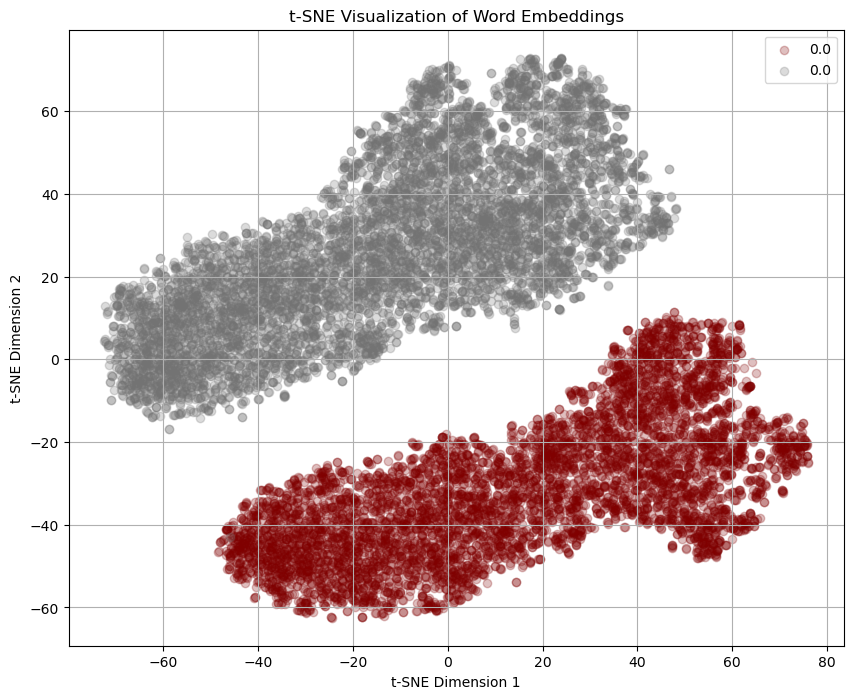

In [176]:
graph_embeddings(non_adoptee_model, adoptee_model, ["non_adoptee", "adoptee"])

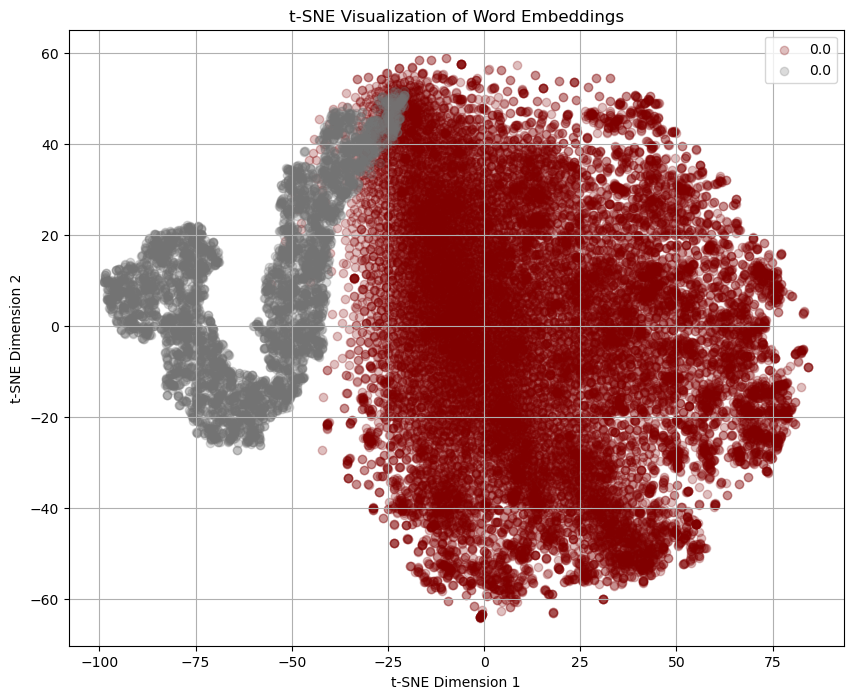

In [177]:
graph_embeddings(r_adoption_model, r_adopted_model, ["non_adoptee", "adoptee"])

In [172]:
def find_cosine_sim(model1, model2, word1, word2, display=True):
    """
    Calculates the cosine similarity between two words for two models
    Inputs
        model1: word2vec model 1
        model2: word2vec model 2
        word1, word2: str 
        diplay: bool determining whether to print the results
    Returns
        the cosine similarity between the word1 and word2 in model1 and model2
    """
    word1_emb_model1 = model1.wv[word1]
    word2_emb_r_model1 = model1.wv[word2]
    cos_sim_model1 = cosine_similarity([word1_emb_model1], [word2_emb_r_model1])

    word1_emb_model2 = model2.wv[word1]
    word2_emb_model2 = model2.wv[word2]
    cos_sim_model2 = cosine_similarity([word1_emb_model2], [word2_emb_model2])
    if display:
        print(f"Cosine similarity between {word1} and {word2} for model1: {cos_sim_model1[0][0]}")
        print(f"Cosine similarity between {word1} and {word2} for model2: {cos_sim_model2[0][0]}")
        
    return cos_sim_model1, cos_sim_model2

In [173]:
cosine_sim1 = find_cosine_sim(r_adopted_model, r_adoption_model, "trauma", "adoption")
cosine_sim2 = find_cosine_sim(adoptee_model, non_adoptee_model, "trauma", "adoption")
cosine_sim3 = find_cosine_sim(r_adopted_adoptees_model, r_adoption_adoptees_model, "trauma", "adoption")

Cosine similarity between trauma and adoption for model1: 0.6991931796073914
Cosine similarity between trauma and adoption for model2: 0.19732362031936646
Cosine similarity between trauma and adoption for model1: 0.1964179277420044
Cosine similarity between trauma and adoption for model2: 0.26756197214126587
Cosine similarity between trauma and adoption for model1: 0.9992290139198303
Cosine similarity between trauma and adoption for model2: 0.22085809707641602


In [174]:
cosine_sim1 = find_cosine_sim(r_adopted_model, r_adoption_model, "child", "save")
cosine_sim2 = find_cosine_sim(adoptee_model, non_adoptee_model, "child", "save")
cosine_sim3 = find_cosine_sim(r_adopted_adoptees_model, r_adoption_adoptees_model, "child", "save")

Cosine similarity between child and save for model1: 0.7254377603530884
Cosine similarity between child and save for model2: 0.06619530916213989
Cosine similarity between child and save for model1: 0.34584587812423706
Cosine similarity between child and save for model2: 0.11032998561859131
Cosine similarity between child and save for model1: 0.9983972311019897
Cosine similarity between child and save for model2: 0.3522150218486786


In [175]:
cosine_sim1 = find_cosine_sim(r_adopted_model, r_adoption_model,  "grateful", "adoptee")
cosine_sim2 = find_cosine_sim(adoptee_model, non_adoptee_model, "grateful", "adoptee")
cosine_sim3 = find_cosine_sim(r_adopted_adoptees_model, r_adoption_adoptees_model, "grateful", "adoptee")

Cosine similarity between grateful and adoptee for model1: 0.4840148687362671
Cosine similarity between grateful and adoptee for model2: 0.2787899374961853
Cosine similarity between grateful and adoptee for model1: 0.19894450902938843
Cosine similarity between grateful and adoptee for model2: 0.39055755734443665
Cosine similarity between grateful and adoptee for model1: 0.9987751245498657
Cosine similarity between grateful and adoptee for model2: 0.2330467849969864


In [179]:
cosine_sim1 = find_cosine_sim(r_adopted_model, r_adoption_model,  "positive", "tra")
cosine_sim2 = find_cosine_sim(adoptee_model, non_adoptee_model, "positive", "tra")
cosine_sim3 = find_cosine_sim(r_adopted_adoptees_model, r_adoption_adoptees_model, "positive", "tra")

Cosine similarity between positive and tra for model1: 0.7171854972839355
Cosine similarity between positive and tra for model2: 0.06756796687841415
Cosine similarity between positive and tra for model1: 0.4398530125617981
Cosine similarity between positive and tra for model2: 0.5983918905258179
Cosine similarity between positive and tra for model1: 0.9863051176071167
Cosine similarity between positive and tra for model2: 0.4556671380996704


In [180]:
cosine_sim1 = find_cosine_sim(r_adopted_model, r_adoption_model, "hate", "tra")
cosine_sim2 = find_cosine_sim(adoptee_model, non_adoptee_model, "hate", "tra")
cosine_sim3 = find_cosine_sim(r_adopted_adoptees_model, r_adoption_adoptees_model, "hate", "tra")

Cosine similarity between hate and tra for model1: 0.8390518426895142
Cosine similarity between hate and tra for model2: -0.01403801143169403
Cosine similarity between hate and tra for model1: 0.35279959440231323
Cosine similarity between hate and tra for model2: 0.555730938911438
Cosine similarity between hate and tra for model1: 0.9868234395980835
Cosine similarity between hate and tra for model2: 0.33151841163635254


Interestingly we see that the cosine similarity between adoption and trauma is much greater for r/Adopted than r/Adoption. This finding is in line with my hypothesis that adoptees are generally more negative on r/Adopted. Furthermore we see that for adoptees in r/Adoption the negativity is much less pronounced. Whereas for adoptees in r/Adopted, this is not the case

In [120]:
r_adopted_model.wv.most_similar('adoption')

[('industry', 0.8026915788650513),
 ('adoptee', 0.7821071147918701),
 ('involve', 0.743355929851532),
 ('relinquishment', 0.7384594082832336),
 ('narrative', 0.7306185960769653),
 ('international', 0.7301176190376282),
 ('corruption', 0.7301141619682312),
 ('pro', 0.7286621332168579),
 ('profit', 0.7269924283027649),
 ('domestic', 0.7237252593040466)]

In [121]:
r_adoption_model.wv.most_similar('adoption')

[('adoption-', 0.6385926604270935),
 ('dia', 0.5602514147758484),
 ('ethical', 0.5280541181564331),
 ('oppose', 0.5117542147636414),
 ('additionally', 0.4965701401233673),
 ('relinquishment', 0.48926401138305664),
 ('typically', 0.48066869378089905),
 ('adopting', 0.46556293964385986),
 ('versus', 0.4654632806777954),
 ('domestic', 0.4582500159740448)]

In [182]:
def plot_tsne(model, num_words=100, random_state=42):
    """
    Plots top N t-SNE word embeddings.
    
    Inputs:
        model: The word2vec model containing word embeddings.
        num_words: int (default=100)
        random_state: int (default=42)

    Plots the t-SNE embeddings
    """
    # Extract the target words and their embeddings
    target_words = model.wv.index_to_key[:num_words]
    words_submatrix = np.array([model.wv[word] for word in target_words])

    # Perform t-SNE
    tsne_words = sklearn.manifold.TSNE(n_components=2, 
                                       random_state=random_state).fit_transform(words_submatrix)

    # Plotting
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(tsne_words[:, 0], tsne_words[:, 1], alpha=0)
    for i, word in enumerate(target_words):
        ax.annotate(word, (tsne_words[:, 0][i], tsne_words[:, 1][i]), 
                    size=20 * (num_words - i) / num_words)

    plt.xticks(())
    plt.yticks(())
    plt.show()

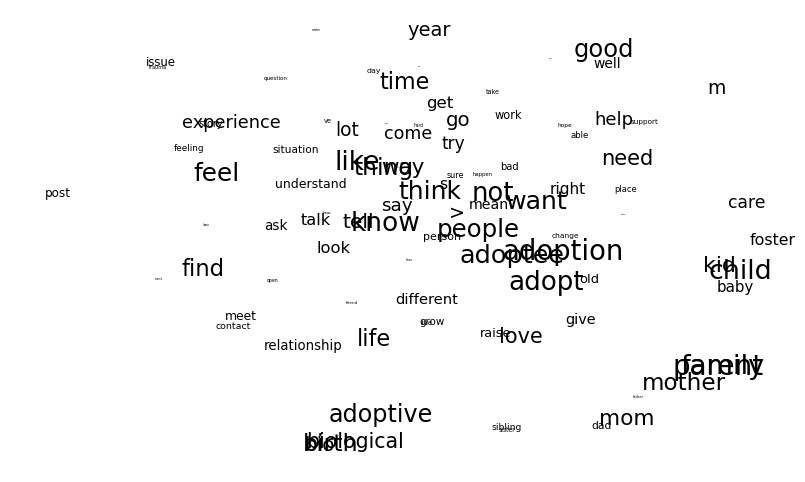

In [231]:
plot_tsne(adoptee_model, num_words=100)

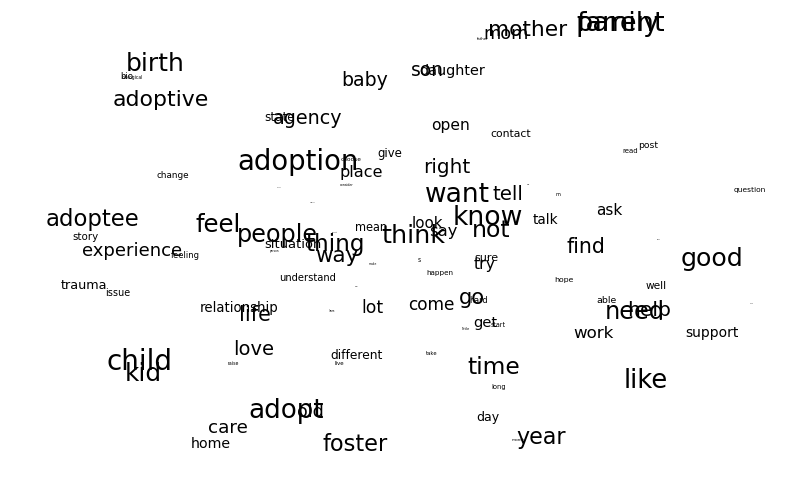

In [183]:
plot_tsne(non_adoptee_model, num_words=100)

In [22]:
# code aided by ChatGPT and content analysis hw4
# get vectors for each row
row_vects = []
for sentence in all_df['norm_tokens']:
    # create a list of word vectors for a given sentence
    vectors = []
    for word in sentence:
        # Check if the word is in the vocabulary of the Word2Vec model
        if word in all_adopt_word2vec.wv:
            vectors.append(all_adopt_word2vec.wv[word])
    if vectors:
        # Calculate the mean vector if at least one word is found in the vocabulary
        row_vects.append(np.mean(vectors, axis=0))
    else:
        # for sentences with no words in vocabulary add an empty vector
        row_vects.append(np.zeros(all_adopt_word2vec.vector_size))  # Use the vector size of the Word2Vec model

row_vects = pd.Series(row_vects)

In [23]:
row_vects.to_pickle("D:\\hw\\adopt-proj\\row_vects.pkl")

Let's find whether or not each of the key words is close in meaning when being used in r/Adoption and r/Adopted

In [86]:
keywords = ["bond", "seek", "grateful", "transracial", "industry", "approval", 
            "adoption", "adoptee", "adopt", "adopted", "trauma", "good", "bad",
            "child", "save", "love", "hate", "happy", "sad", "angry"]

def get_similarities(keywords, model1, model2):
    """
    Finds the cosine similarity between two word2vec models for a list of keywords.
    Inputs:
        keywords: list of str
        r_adopted_model: word2vec model
        r_adoption_model: word2vec model
    Returns a dictionary mapping keys to the cosine similarity between the two models.
    """
    similarities = {}
    for keyword in keywords:
        try:
            vector_adopted = model1.wv[keyword]
            vector_adoption = model2.wv[keyword]
            similarity = 1 - cosine(vector_adopted, vector_adoption)
            similarities[keyword] = similarity
        except KeyError:
            similarities[keyword] = "Word not found in one of the models."

    return similarities

In [87]:
get_similarities(keywords, r_adopted_model, r_adoption_model)

{'bond': -0.15175579488277435,
 'seek': -0.2268764227628708,
 'grateful': -0.19217661023139954,
 'transracial': -0.05062051862478256,
 'industry': 0.17956453561782837,
 'approval': 0.03199252858757973,
 'adoption': -0.1373712569475174,
 'adoptee': -0.16728758811950684,
 'adopt': -0.2455664873123169,
 'adopted': 0.0359882228076458,
 'trauma': -0.05348401889204979,
 'good': -0.31631654500961304,
 'bad': -0.09666292369365692,
 'child': -0.1786220520734787,
 'save': 0.025004249066114426,
 'love': -0.2885979413986206,
 'hate': -0.07111009210348129,
 'happy': -0.15548314154148102,
 'sad': -0.12258635461330414,
 'angry': -0.05174421891570091}

In [88]:
get_similarities(keywords, adoptee_model, non_adoptee_model)

{'bond': 0.38437241315841675,
 'seek': 0.16076724231243134,
 'grateful': 0.45100778341293335,
 'transracial': 0.061191461980342865,
 'industry': 0.27541348338127136,
 'approval': 0.6695536971092224,
 'adoption': 0.5073298811912537,
 'adoptee': -0.056700676679611206,
 'adopt': 0.27125269174575806,
 'adopted': 0.6001583337783813,
 'trauma': 0.34761086106300354,
 'good': 0.16712762415409088,
 'bad': 0.303008496761322,
 'child': -0.042299337685108185,
 'save': 0.12295631319284439,
 'love': 0.2635558545589447,
 'hate': 0.2835824489593506,
 'happy': 0.26672235131263733,
 'sad': 0.37462371587753296,
 'angry': 0.2550153434276581}

In [89]:
get_similarities(keywords, r_adoption_adoptees_model, r_adopted_adoptees_model)

{'bond': 0.3173474967479706,
 'seek': 0.30030035972595215,
 'grateful': 0.3994129002094269,
 'transracial': 0.21451137959957123,
 'industry': 0.2947518527507782,
 'approval': 0.699675977230072,
 'adoption': 0.09742536395788193,
 'adoptee': 0.02635442651808262,
 'adopt': 0.2384576052427292,
 'adopted': 0.6952021718025208,
 'trauma': 0.2110527604818344,
 'good': 0.27848976850509644,
 'bad': 0.3218405544757843,
 'child': 0.20079012215137482,
 'save': 0.40664851665496826,
 'love': 0.2910844087600708,
 'hate': 0.4425756633281708,
 'happy': 0.33523717522621155,
 'sad': 0.4187967777252197,
 'angry': 0.4098033607006073}

Some very interesting results. We see that for some reason adoption and adoptee have similarities close to 0 for adoptees in the two subreddits

Let's investigate grateful, industry, good, and love

In [84]:
r_adoption_model.wv.most_similar('grateful')

[('thankful', 0.8498601913452148),
 ('appreciative', 0.7273564338684082),
 ('lucky', 0.710163950920105),
 ('blessed', 0.6650969982147217),
 ('fortunate', 0.642538845539093),
 ('greatful', 0.6018967032432556),
 ('bless', 0.6018544435501099),
 ('eternally', 0.5747414231300354),
 ('gratitude', 0.5677196383476257),
 ('privileged', 0.5589848756790161)]

In [85]:
r_adopted_model.wv.most_similar('grateful')

[('differently', 0.9410569071769714),
 ('suppose', 0.9268365502357483),
 ('lucky', 0.9257771968841553),
 ('horrible', 0.9201987981796265),
 ('assume', 0.9196292161941528),
 ('idea', 0.9130794405937195),
 ('unconditionally', 0.910982072353363),
 ('true', 0.9108777642250061),
 ('matter', 0.9083564877510071),
 ('perfect', 0.9023029208183289)]

In [67]:
r_adoption_model.wv.most_similar('love')

[('unconditionally', 0.7264087200164795),
 ('loving', 0.6833972334861755),
 ('cherish', 0.6571432948112488),
 ('unconditional', 0.6459483504295349),
 ('adore', 0.6046385765075684),
 ('deserve', 0.5919321179389954),
 ('dearly', 0.5877115726470947),
 ('worthy', 0.5649158954620361),
 ('nurture', 0.5516114830970764),
 ('wonderful', 0.5446344017982483)]

In [68]:
r_adopted_model.wv.most_similar('love')

[('choose', 0.8637171983718872),
 ('respect', 0.8444322943687439),
 ('aborted', 0.8378012776374817),
 ('supportive', 0.8248913884162903),
 ('deserve', 0.8239160776138306),
 ('wonderful', 0.812536358833313),
 ('want', 0.8124901056289673),
 ('expect', 0.8106884360313416),
 ('conceal', 0.8079957365989685),
 ('unconditionally', 0.8070527911186218)]

## Topical Modeling

In [57]:
def plotSilhouette(n_clusters, X):
    """
    Graphs the silhouette score for a given number of clusters
    Returns the average silhouette score
    """
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    cmap = matplotlib.cm.get_cmap("nipy_spectral")

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Plot showing the actual clusters formed
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')
    plt.show()
    print(f"For n_clusters = {n_clusters}, The average silhouette_score is : {silhouette_avg:.3f}")
    return silhouette_avg


In [84]:
r_adoption_tf_idf_vects = tfidf_vectorizer.fit_transform(all_df[all_df.subreddit == "r/Adoption"].norm_tokens.apply(lambda x: " ".join(x)))

In [85]:
r_adopted_tf_idf_vects = tfidf_vectorizer.fit_transform(all_df[all_df.subreddit == "r/Adopted"].norm_tokens.apply(lambda x: " ".join(x)))

In [86]:
labeled_tf_idf_vects = tfidf_vectorizer.fit_transform(labeled_df.norm_tokens.apply(lambda x: " ".join(x)))

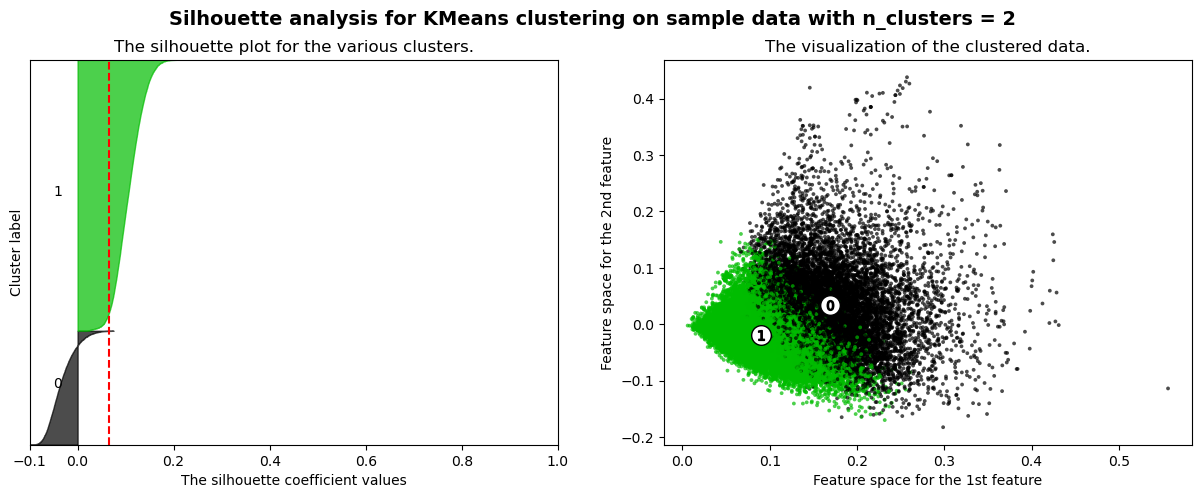

For n_clusters = 2, The average silhouette_score is : 0.065


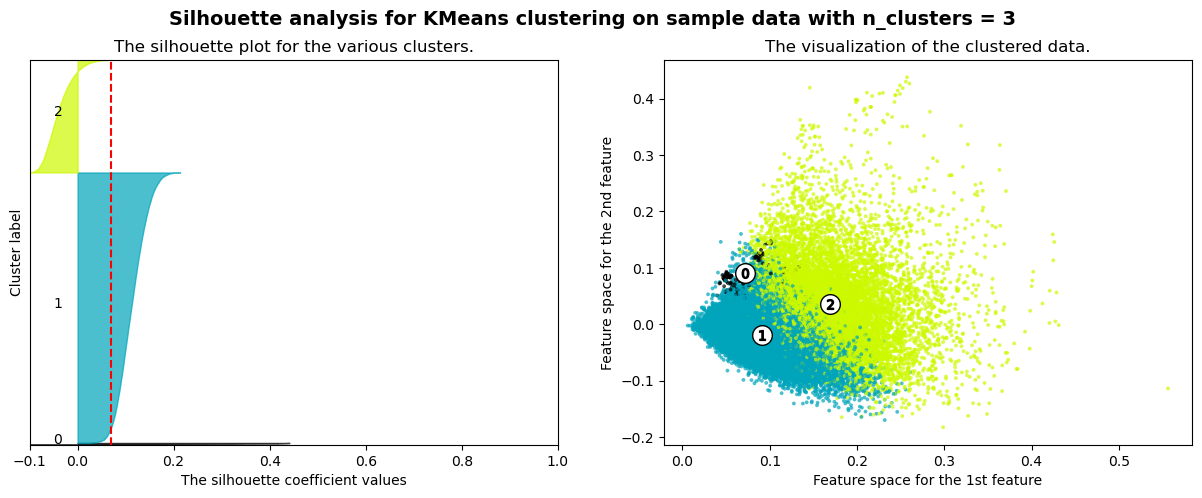

For n_clusters = 3, The average silhouette_score is : 0.069


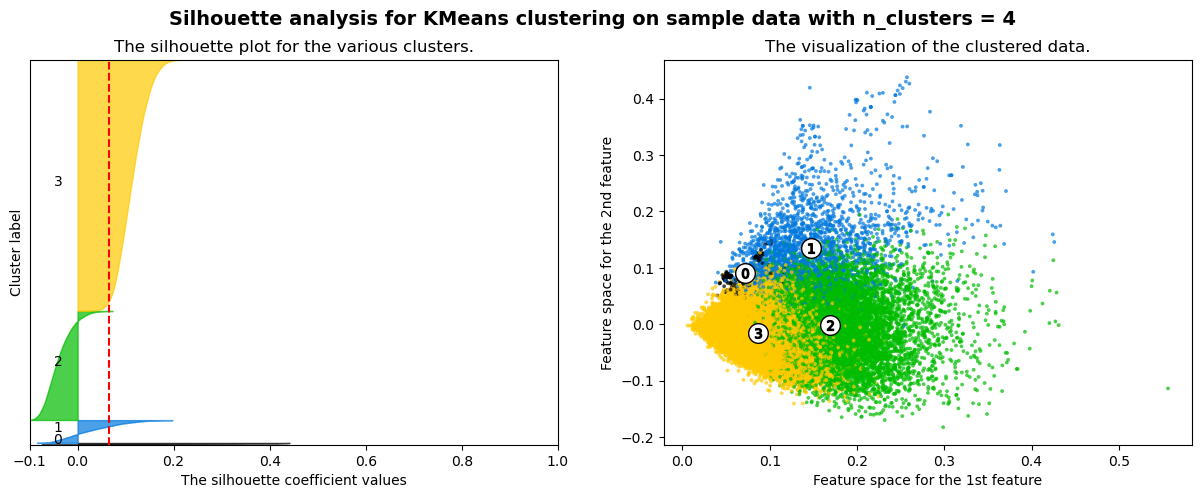

For n_clusters = 4, The average silhouette_score is : 0.065


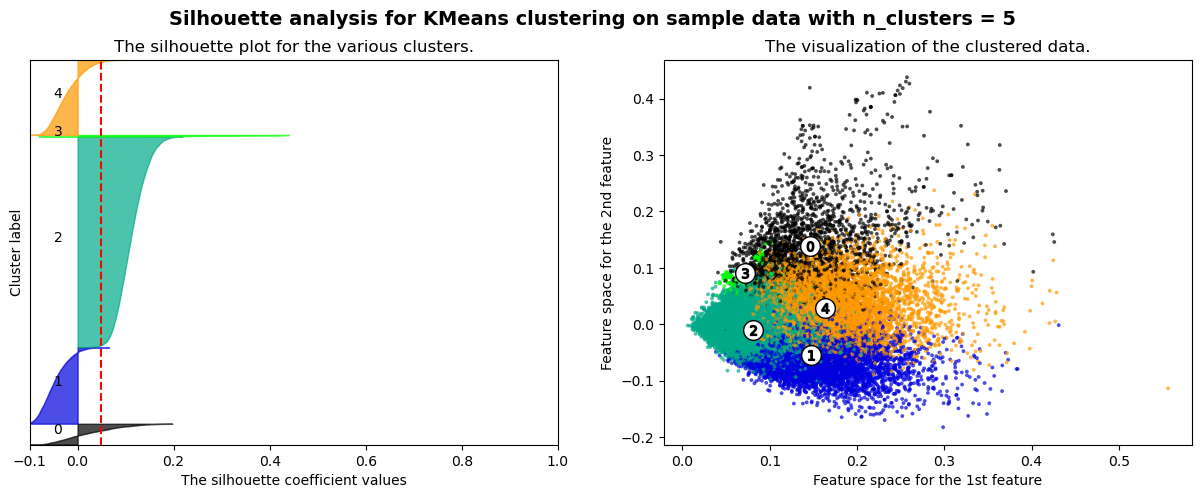

For n_clusters = 5, The average silhouette_score is : 0.049


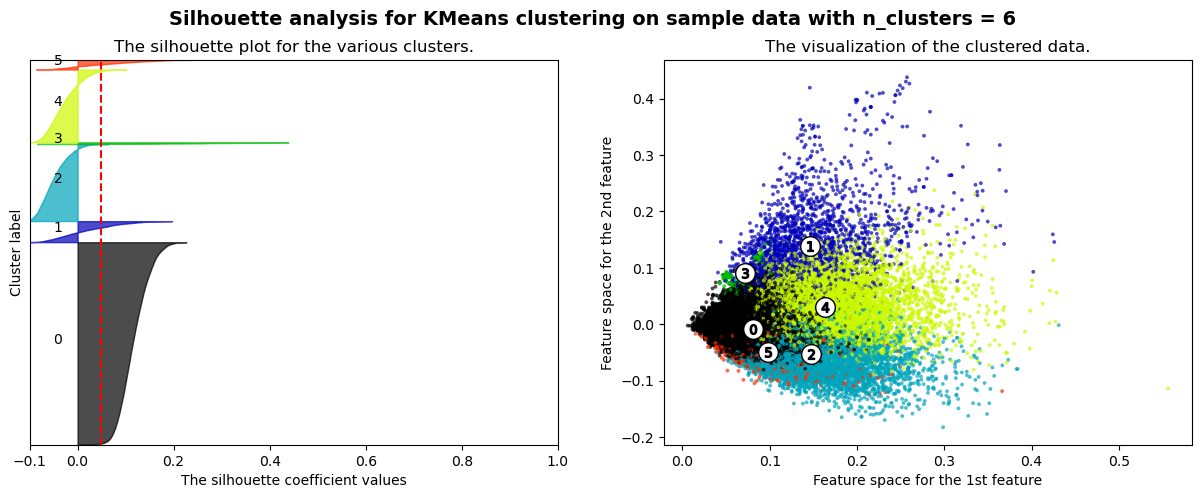

For n_clusters = 6, The average silhouette_score is : 0.049


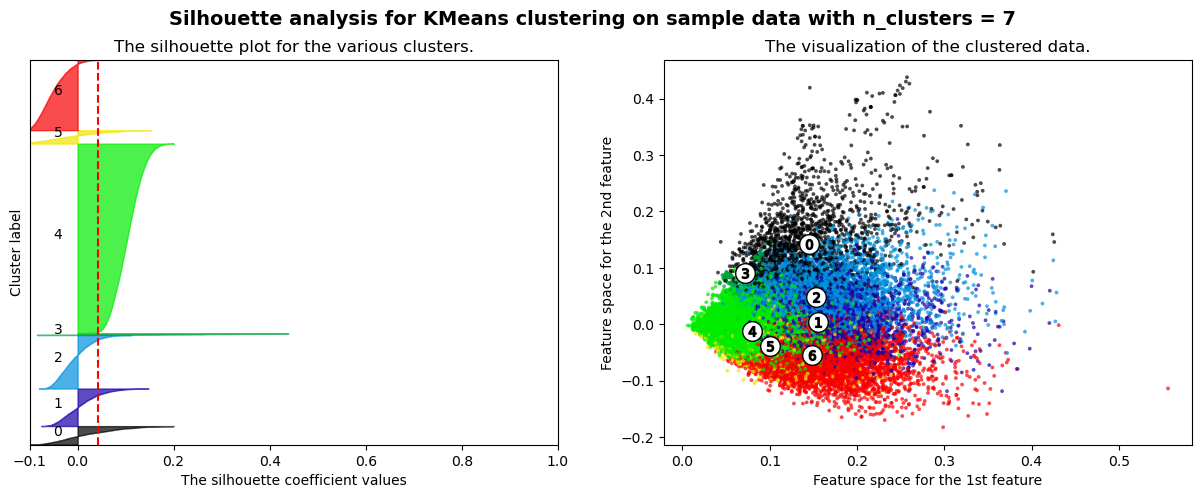

For n_clusters = 7, The average silhouette_score is : 0.042


In [88]:
svd = sklearn.decomposition.TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(labeled_tf_idf_vects)
silhouette_scores = [plotSilhouette(i, X_reduced) for i in range(2,8)]

It seems that the optimal amount of clusters ought to be around 2 or 4. Otherwise it seems to generally decrease in the average silhouette score when number of topics increases

Now let's do it for adoptees and non adoptees.

In [89]:
adoptee_tf_idf_vects = tfidf_vectorizer.fit_transform(all_df[all_df.is_adoptee == 1].cleaner_text)
non_adoptee_tf_idf_vects = tfidf_vectorizer.fit_transform(all_df[all_df.is_adoptee == 0].cleaner_text)

Back to subreddits

In [90]:
# drop the words missing from vocab
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

r_adoption_df = labeled_df[labeled_df['subreddit'] == 'r/Adoption']
r_adopted_df = labeled_df[labeled_df['subreddit'] == 'r/Adopted']
adoptee_df = labeled_df[labeled_df.is_adoptee == 1]
non_adoptee_df = labeled_df[labeled_df.is_adoptee == 0]

# find reduced tokens
r_adoption_df.loc[:,'reduced_tokens'] = r_adoption_df.norm_tokens.apply(lambda x: dropMissing(x, tfidf_vectorizer.vocabulary_.keys()))

r_adopted_df.loc[:,'reduced_tokens'] = r_adopted_df.norm_tokens.apply(lambda x: dropMissing(x, tfidf_vectorizer.vocabulary_.keys()))

adoptee_df.loc[:,'reduced_tokens'] = adoptee_df.norm_tokens.apply(lambda x: dropMissing(x, tfidf_vectorizer.vocabulary_.keys()))

non_adoptee_df.loc[:,'reduced_tokens'] = non_adoptee_df.norm_tokens.apply(lambda x: dropMissing(x, tfidf_vectorizer.vocabulary_.keys()))



C:\Users\Ethan\AppData\Local\Temp\ipykernel_12004\990638791.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_adoption_df.loc[:,'reduced_tokens'] = r_adoption_df.norm_tokens.apply(lambda x: dropMissing(x, tfidf_vectorizer.vocabulary_.keys()))
C:\Users\Ethan\AppData\Local\Temp\ipykernel_12004\990638791.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_adopted_df.loc[:,'reduced_tokens'] = r_adopted_df.norm_tokens.apply(lambda x: dropMissing(x, tfidf_vectorizer.vocabulary_.keys()))
C:\Users\Ethan\App

In [91]:
# For Subreddit 1
dict_r_adoption = gensim.corpora.Dictionary(r_adoption_df['reduced_tokens'])
corpus_r_adoption = [dict_r_adoption.doc2bow(text) for text in r_adoption_df['reduced_tokens']]

# For Subreddit 2
dict_r_adopted = gensim.corpora.Dictionary(r_adopted_df['reduced_tokens'])
corpus_r_adopted = [dict_r_adopted.doc2bow(text) for text in r_adopted_df['reduced_tokens']]

# for adoptees
dict_adoptee = gensim.corpora.Dictionary(adoptee_df['reduced_tokens'])
corpus_adoptee = [dict_adoptee.doc2bow(text) for text in adoptee_df['reduced_tokens']]

# for non adoptees
dict_non_adoptee = gensim.corpora.Dictionary(non_adoptee_df['reduced_tokens'])
corpus_non_adoptee = [dict_r_adopted.doc2bow(text) for text in non_adoptee_df['reduced_tokens']]

In [117]:
# LDA for Subreddit 1
lda_r_adoption = gensim.models.ldamodel.LdaModel(corpus=corpus_r_adoption, id2word=dict_r_adoption, 
                                                  num_topics=3, alpha='auto', eta='auto')

# LDA for Subreddit 2
lda_r_adopted = gensim.models.ldamodel.LdaModel(corpus=corpus_r_adopted, id2word=dict_r_adopted, 
                                                  num_topics=3, alpha='auto', eta='auto')


In [118]:
# LDA For adoptee
lda_adoptee = gensim.models.ldamodel.LdaModel(corpus=corpus_adoptee, id2word=dict_adoptee, 
                                                  num_topics=3, alpha='auto', eta='auto')

# LDA for non adoptee
lda_non_adoptee = gensim.models.ldamodel.LdaModel(corpus=corpus_non_adoptee, id2word=dict_non_adoptee, 
                                                  num_topics=3, alpha='auto', eta='auto')


In [119]:
# create ldas_dfs for both subreddits

lda_r_adoption_df = pd.DataFrame({
        'user' : r_adoption_df['user'],
        'topics' : [lda_r_adoption[dict_r_adoption.doc2bow(l)] for l in r_adoption_df['reduced_tokens']]})


lda_r_adopted_df = pd.DataFrame({
        'user' : r_adopted_df['user'],
        'topics' : [lda_r_adopted[dict_r_adopted.doc2bow(l)] for l in r_adopted_df['reduced_tokens']]})


# create ldas_dfs for adoptee status

lda_adoptee_df = pd.DataFrame({
        'user' : adoptee_df['user'],
        'topics' : [lda_adoptee[dict_adoptee.doc2bow(l)] for l in adoptee_df['reduced_tokens']]})


lda_non_adoptee_df = pd.DataFrame({
        'user' : non_adoptee_df['user'],
        'topics' : [lda_non_adoptee[dict_non_adoptee.doc2bow(l)] for l in non_adoptee_df['reduced_tokens']]})

In [120]:
#Dict to temporally hold the probabilities
r_adoption_topicsProbDict = {i : [0] * len(lda_r_adoption_df) for i in range(lda_r_adoption.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(lda_r_adoption_df['topics']):
    for topicNum, prob in topicTuples:
        r_adoption_topicsProbDict[topicNum][index] = prob

for topicNum in range(lda_r_adoption.num_topics):
    lda_r_adoption_df['topic_{}'.format(topicNum)] = r_adoption_topicsProbDict[topicNum]


#Dict to temporally hold the probabilities
r_adopted_topicsProbDict = {i : [0] * len(lda_r_adopted_df) for i in range(lda_r_adopted.num_topics)}

for index, topicTuples in enumerate(lda_r_adopted_df['topics']):
    for topicNum, prob in topicTuples:
        r_adopted_topicsProbDict[topicNum][index] = prob
for topicNum in range(lda_r_adopted.num_topics):
    lda_r_adopted_df['topic_{}'.format(topicNum)] = r_adopted_topicsProbDict[topicNum]

In [121]:
# for adoptee
#Dict to temporally hold the probabilities
adoptee_topicsProbDict = {i : [0] * len(lda_adoptee_df) for i in range(lda_adoptee.num_topics)}

for index, topicTuples in enumerate(lda_adoptee_df['topics']):
    for topicNum, prob in topicTuples:
        adoptee_topicsProbDict[topicNum][index] = prob
for topicNum in range(lda_adoptee.num_topics):
    lda_adoptee_df['topic_{}'.format(topicNum)] = adoptee_topicsProbDict[topicNum]


# for non adoptee
    
non_adoptee_topicsProbDict = {i : [0] * len(lda_non_adoptee_df) for i in range(lda_non_adoptee.num_topics)}

for index, topicTuples in enumerate(lda_non_adoptee_df['topics']):
    for topicNum, prob in topicTuples:
        non_adoptee_topicsProbDict[topicNum][index] = prob
for topicNum in range(lda_non_adoptee.num_topics):
    lda_non_adoptee_df['topic_{}'.format(topicNum)] = non_adoptee_topicsProbDict[topicNum]


In [122]:
lda_r_adoption_df.columns

Index(['user', 'topics', 'topic_0', 'topic_1', 'topic_2'], dtype='object')

In [123]:
r_adoption_ldaDFV = lda_r_adoption_df[:15][['topic_%d' %x for x in range(3)]]
r_adoption_ldaDFVisN = lda_r_adoption_df[:15][['user']]
r_adoption_ldaDFVis = r_adoption_ldaDFV.values
r_adoption_ldaDFVisNames = r_adoption_ldaDFVisN.values
r_adoption_ldaDFV

,topic_0,topic_1,topic_2
17161,0.669627,0.142308,0.188065
17163,0.792832,0.000000,0.200273
17182,0.904463,0.014216,0.081322
17187,0.365512,0.018589,0.615899
17197,0.821553,0.025580,0.152866
17206,0.127468,0.420131,0.452401
17207,0.084447,0.090364,0.825189
17216,0.326569,0.270613,0.402817
17217,0.538654,0.438600,0.022746
17232,0.046893,0.444572,0.508535


In [125]:
r_adopted_ldaDFV = lda_r_adopted_df[:15][['topic_%d' %x for x in range(3)]]
r_adopted_ldaDFVisN = lda_r_adopted_df[:15][['user']]
r_adopted_ldaDFVis = r_adopted_ldaDFV.values
r_adopted_ldaDFVisNames = r_adopted_ldaDFVisN.values
r_adopted_ldaDFV

,topic_0,topic_1,topic_2
0,0.026120,0.954703,0.019178
18,0.831179,0.061895,0.106926
19,0.078704,0.616324,0.304972
24,0.000000,0.791004,0.201776
26,0.044168,0.921338,0.034494
31,0.046746,0.102614,0.850639
40,0.017114,0.024261,0.958624
45,0.037079,0.944694,0.018227
47,0.633773,0.360493,0.000000
48,0.588674,0.024473,0.386853


In [126]:
# for adoptee
adoptee_ldaDFV = lda_adoptee_df[:15][['topic_%d' %x for x in range(3)]]
adoptee_ldaDFVisN = lda_adoptee_df[:15][['user']]
adoptee_ldaDFVis = adoptee_ldaDFV.values
adoptee_ldaDFVisNames = adoptee_ldaDFVisN.values
adoptee_ldaDFV

,topic_0,topic_1,topic_2
0,0.843471,0.020361,0.136168
18,0.173261,0.022122,0.804617
19,0.013359,0.000000,0.977595
24,0.000000,0.000000,0.985074
26,0.043330,0.032963,0.923707
31,0.049011,0.030827,0.920163
40,0.291286,0.134624,0.574089
45,0.070515,0.017304,0.912180
47,0.118645,0.253435,0.627919
48,0.018837,0.602864,0.378299


In [127]:
# for adoptee
non_adoptee_ldaDFV = lda_non_adoptee_df[:15][['topic_%d' %x for x in range(3)]]
non_adoptee_ldaDFVisN = lda_non_adoptee_df[:15][['user']]
non_adoptee_ldaDFVis = non_adoptee_ldaDFV.values
non_adoptee_ldaDFVisNames = non_adoptee_ldaDFVisN.values
non_adoptee_ldaDFV

,topic_0,topic_1,topic_2
422,0.030222,0.472282,0.497495
1457,0.101215,0.186513,0.712272
3596,0.433502,0.141254,0.425244
3686,0.118680,0.496790,0.384530
3725,0.017261,0.080312,0.902427
8721,0.230010,0.246604,0.523386
9580,0.019149,0.183056,0.797795
9982,0.092400,0.241895,0.665706
13827,0.159590,0.147326,0.693084
14200,0.025803,0.045239,0.928958


In [128]:
#### minor data viz for topic modeling

In [129]:
def plot_topics(lda, ldaDFVis, ldaDFVisNames, N):
    """
    Plot the topics for N examples
    Inputs:
        lda: LDA model
        ldDFVis: list of lists containing LDA values for each topic in a given row
        ldaDFVisNames: list of list containing a single name each for every row
        N: the number of rows to compare
    Returns None, graphs N rows for set topics
    """
    
    ind = np.arange(N)
    K = lda.num_topics  # N documents, K topics
    ind = np.arange(N)  # the x-axis locations for the novels
    width = 0.5  # the width of the bars
    plots = []
    height_cumulative = np.zeros(N)

    for k in range(K):
        color = plt.cm.coolwarm(k/K, 1)
        if k == 0:
            p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
        else:
            p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += ldaDFVis[:, k]
        plots.append(p)


    plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
    plt.ylabel('Topics')

    plt.title('Topics in Reddit Post')
    plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

    plt.yticks(np.arange(0, 1, 15))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

    plt.show()
    return

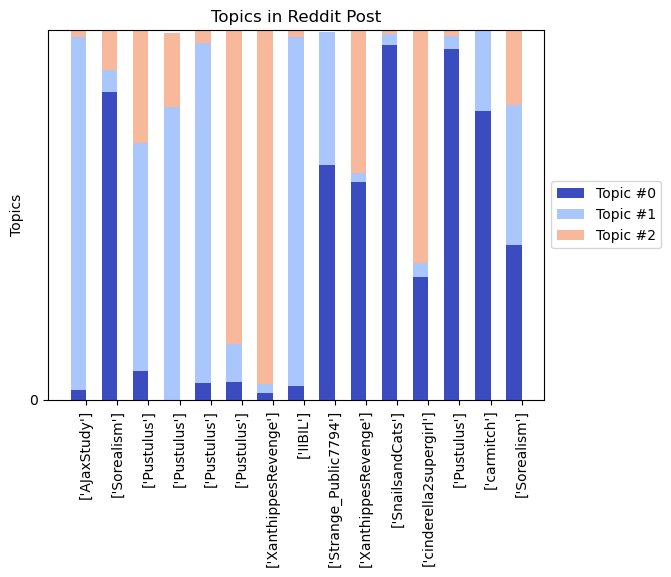

In [130]:
# plot for r/Adoption and r/Adopted
plot_topics(lda_r_adopted, r_adopted_ldaDFVis, r_adopted_ldaDFVisNames, 15)

In [131]:
r_adopted_df[:15].full_text

0      /r/Adopted is for Adoptees Only.. Due to recen...
18     Your feelings make sense, and it’s good you’re...
19     The way I handle my birthday is to be really s...
24     I called my 1962 maternity home a couple weeks...
26     I know, I'm like, if you aren't keeping these ...
31     Thanks, I think that's my next step. It's craz...
40     I completely hear you. It is horrible how, in ...
45     That's so much! But I'm so glad you found out....
47     Bitterness about school. It was so long ago no...
48     Punnet square assignment in 8th grade. \nFamil...
49     Same here!! I had a family tree project in 6th...
52     This was always so heartbreaking for me.\n* Fa...
56     I was the teacher's pet in third grade until t...
100    Constant Frustration with my Adoptive Family. ...
112    This comment was reported for breaking Rule 2 ...
Name: full_text, dtype: object

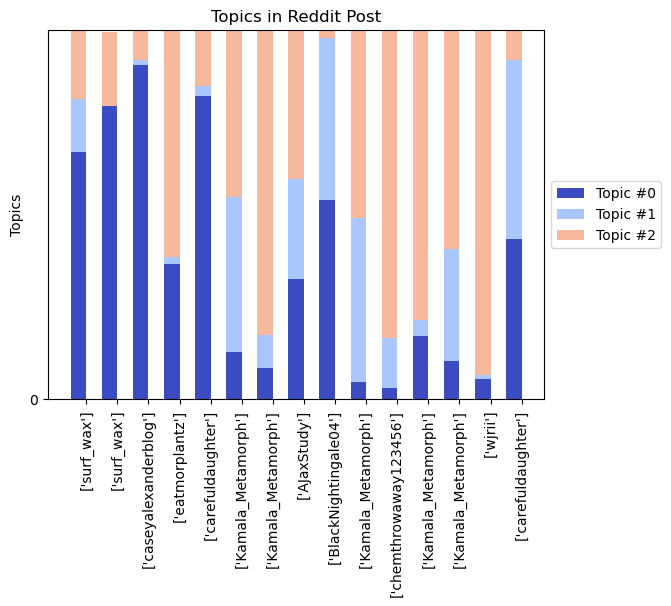

In [132]:
plot_topics(lda_r_adoption, r_adoption_ldaDFVis, r_adoption_ldaDFVisNames, 15)

Let's take a look at the text to discern topical meanings

In [140]:
r_adopted_df[:15].full_text.iloc[0]

'/r/Adopted is for Adoptees Only.. Due to recent events we will be strict on our adoptee-only rule.   \nIf you have any questions regarding the adoption process, or wanted to ask adoptees questions - Please visit /r/adoption\n'

In [141]:
r_adopted_df[:15].full_text.iloc[7]

"That's so much! But I'm so glad you found out. Our stories aren't quite the same (they never are), but I am also an international adoptee who was kept a secret. Hurts a bit to know that, but my birth mom told her new partner and my siblings. I hope you can meet your family!\n"

In [142]:
r_adoption_df[:15].full_text.iloc[0]

'Search resources. Welcome to the weekly search resource thread!  This is a post we\'re going to be using to assist people with searches, at the suggestion of /u/Kamala_Metamorph, who realized exactly how many search posts we get when she was going through tagging our recent history.  Hopefully this answers some questions for people and helps us build a document that will be useful for future searches.\nI\'ve put together a list of resources that can be built upon in future iterations of this thread.  Please comment if you have a resource, such as a list of states that allow OBC access, or a particularly active registry.  I know next to nothing about searching internationally and I\'d love to include some information on that, too.\nPlease note that you are unlikely to find your relative in this subreddit.  In addition, reddit.com has rules against posting identifying information.  It is far better to take the below resources, or to comment asking for further information how to search, 

In [144]:
r_adoption_df[:15].full_text.iloc[1]

'I\'m not exactly sure how they get their information, but I suspect they do have access to certain Australian records.  I did a search for "New South Wales public records" and came up with some promising sources -- other states are probably similar (or maybe public records are issued by the city/shire?).  I imagine that the Search Squad volunteers would be able to apply what they know about searching in the US to an Australian search, even if they have no special access to subscription-only databases there.  It\'s absolutely worth a try.\n'

In [143]:
r_adoption_df[:15].full_text.iloc[2]

"This is great info (I take an unplanned hiatus and look what happens). NICE WORK! \nMy sister in law used ancestry.com's DNA feature and was able to find her cousins and via them, track down her father. Super neat. \n"

In [107]:
r_adoption_df[:15].full_text.iloc[6]

"I decided to repost this as a top level comment so that it gets seen, instead of making you click on three <click to expand this thread> to get to this child comment. \nIf you are a PAP looking to make an ethical choice to adopt, this is why I think it is more ethical to adopt older children and teenagers from foster care rather than babies:\n(original link)\n\nBecause most younger children get reunified with parents or adopted by kin there is a greater need to adopt older, not younger, kids\n\nDopey-NipNips has the right answer. I don't think you were trying to start an argument, but Adptee is right too, so I wanted to highlight their comment to you. \nFor a spelling out of the answer, you can see Appendix F, page 86, Children Waiting to be Adopted:\nhttps://www.acf.hhs.gov/sites/default/files/documents/cb/cwo2018.pdf#page=87\nWhile there are children 0-7ish who are waiting to be adopted, you can see that the largest group (27%) of TPR'd children live with kinship placements. There's

In [108]:
r_adoption_df[:15].full_text.iloc[8]

'I too was shocked to read that thread.\nI anticipated more adult adoptees to say they were glad they had given life rather than not existing because they could have been aborted...\n'

In [109]:
r_adoption_df[:15].full_text.iloc[10]

'7+ was given as one example of an ethical adoption situation; of course there are others, and of course the child can be younger than seven. It wasn’t meant to be taken as a rule that must be followed in order to make an adoption ethical. \nWhat if someone said, “many mammals walk on four legs, for example dogs.”\nWould you ask, “what about horses?”\n\n(Edit: said more succinctly: age isn’t what makes an adoption ethical. It’s the child’s need for a safe, stable, and permanent home — regardless of age — when the child’s parents/family aren’t capable/willing to provide one.)\n'

In [145]:
r_adoption_df[:15].full_text.iloc[14]

'I’m so sorry you’re feeling like this - it sounds difficult and lonely. But you are not alone. There are loads of people, some of whom are adopted and some who aren’t, who feel like outsiders in their own families. It always sucks. \nSo what do you do? You do what The Gays have been doing since time immemorial - you make your own family. You find your own people to be part of your life and you work on building and maintaining those relationships so that hopefully people who come into your orbit don’t leave it feeling the same way you do now, rejected and alone. You create and carve out a comfortable space for yourself and your loved ones in the world. \nYou’d benefit from therapy. I think you’d especially benefit from a particular method called Cognitive Behavioral Therapy, which teaches you a lot of methods for working through really tough emotions. Distress tolerance is crucial for those of us with trauma in our past, otherwise we’ll forever be incredibly reactive and just incredibl

In [147]:
r_adoption_df[:15].full_text.iloc[5]

'If you are new to Adoption or our sub, please read this:. eta: Permanently saved in the wiki here:\nhttps://www.reddit.com/r/Adoption/wiki/adoption_in_2022\n.\nHi r/Adoption friends :wave: \nThis message is largely for adults like me, who are looking to adopt a child. In adoption land, we\'re known as PAPs - Prospective Adoptive Parents, HAPs - Hopeful Adoptive Parents, or Waiting Parents.  \nI don\'t know if you\'ve heard, but there is a little discussion in the world this week about Roe v. Wade getting overturned, because (paraphrasing) \'women who don\'t want to parent can "rest assured" that safe haven laws means their babies will get adopted and they don\'t have the burden of parenting\'.*\nIf this is making you research adoption for the first time..... I beg you to learn\nmore\nbefore you speak or ask questions. \nFirst of all, you should know that fewer than 20,000 babies (under 2 years old) are adopted each year. There are (literally) a million parents interested in adoption. 

In [146]:
r_adoption_df[:15].full_text.iloc[9]

"\nthe vast majority would agree that unethical adoption is objectionable.\n\nAnd most people don't realize when they may be participating in a questionably ethical (cough unethical cough) adoption industry. \nthanks!\n"

In [153]:
r_adopted_df[:15].full_text.iloc[3]

'I called my 1962 maternity home a couple weeks ago, just to see if they would give me one piece of information. I told them that after they sold me my "de-identified file" 20 years ago, I took a DNA test and with lots of money and work, re-identified every single person in my file. (I told them some actual names to prove it.)\nExcept one name. My own. On my original birth record, the first time someone put a pen to paper to document my existence ... my name is censored. I said could you just tell me what was under there? I\'ve literally identified every single person in my file.\nNope. Telling me my "Home Name" would be another HIPAA identifier, so I can\'t know that. My two options are to get a permission slip from my 83-year-old mother, if she\'s even alive, or get a lawyer and go to court. They\'ll tell me my home name only with a court order, or my mother\'s permission.\n'

In [155]:
r_adopted_df[:15].full_text.iloc[7]

"That's so much! But I'm so glad you found out. Our stories aren't quite the same (they never are), but I am also an international adoptee who was kept a secret. Hurts a bit to know that, but my birth mom told her new partner and my siblings. I hope you can meet your family!\n"

In [151]:
r_adopted_df[:15].full_text.iloc[1]

'Your feelings make sense, and it’s good you’re preparing yourself and have a support system. Birthdays can even be rough for those of us that have known our whole life so be kind to yourself and know your feelings are valid and ok.\n'

In [152]:
r_adopted_df[:15].full_text.iloc[10]

'Same here!! I had a family tree project in 6th grade that literally had a line on the handout ‘if you’re adopted, see the teacher for further instruction’. So I did. She asked when I was adopted, I said at birth, and she said ‘oh okay then just do it on your family you have now’. \nOf course the other kids found out. Of course there was teasing involved. Of course more of the ‘you were chosen’ narrative. I wasn’t chosen. I was the first baby my adopters could get their hands on.\n'

In [156]:
r_adopted_df[:15].full_text.iloc[5]

"Thanks, I think that's my next step. It's crazy how Texas records are revealed -- based upon whether you get a good judge or not.\n"

In [157]:
r_adopted_df[:15].full_text.iloc[6]

'I completely hear you. It is horrible how, in this day and age, people just vanish without a trace and do not give a fuck how it affects you. It really hurts. I read a lot about the concept of impermanence in Buddhism and how everything changes, and try to appreciate people for the lessons they imparted upon me, and think of them like a river, like water slipping through my fingers in a river. Or some shit like that. Otherwise I might scream.\n'

Now let's look at adoptee vs non adoptee too

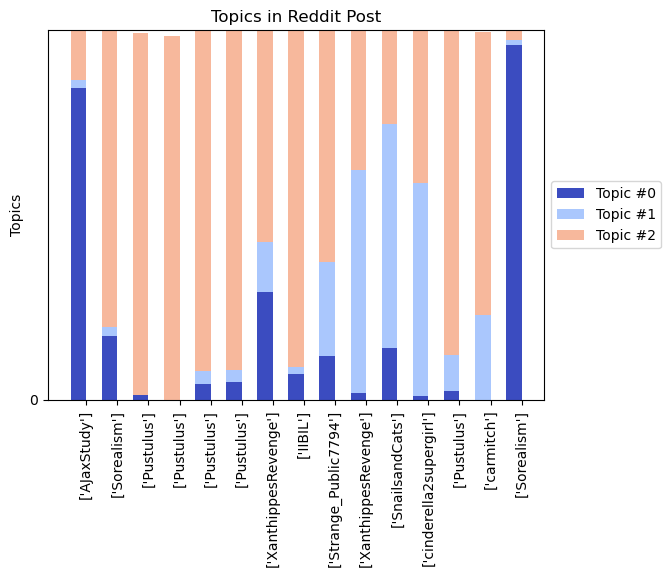

In [133]:
# plot for adoptees
plot_topics(lda_adoptee, adoptee_ldaDFVis, adoptee_ldaDFVisNames, 15)

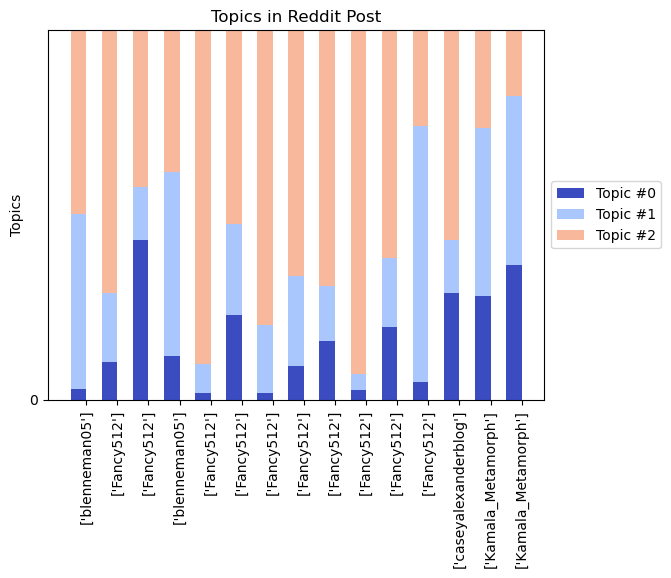

In [134]:
# plot for non adoptees
plot_topics(lda_non_adoptee, non_adoptee_ldaDFVis, non_adoptee_ldaDFVisNames, 15)

Let's take a look inside some of these posts

In [113]:
adoptee_df[:15].full_text.iloc[0]

'/r/Adopted is for Adoptees Only.. Due to recent events we will be strict on our adoptee-only rule.   \nIf you have any questions regarding the adoption process, or wanted to ask adoptees questions - Please visit /r/adoption\n'

In [79]:
adoptee_df[:15].full_text.iloc[4]

"I know, I'm like, if you aren't keeping these records for me, then why are you keeping them at all? I'M THE PERSON ON THE RECORDS ... I give you permission to tell me about myself.\n"

In [80]:
adoptee_df[:15].full_text.iloc[5]

"Thanks, I think that's my next step. It's crazy how Texas records are revealed -- based upon whether you get a good judge or not.\n"

In [81]:
adoptee_df[:15].full_text.iloc[8]

'Bitterness about school. It was so long ago now, and it\'s such a small thing, but it still leaves me furious and bitter to think about the time I got low marks (nearly failed) a "stages of human growth" project I did that required us to use pictures of ourselves growing up.\nI didn\'t have pictures of myself as an infant, so I used the youngest pictures of me I had and my teacher docked huge numbers of points because I "obviously didn\'t understand the assignment", even though he admitted that the rest of it was done correctly. I had an A+ average in the class (thanks, The Trauma) and this huge project dragged it down.\nI hated the idea of disclosing to this teacher who already disliked me, but I did, and he STILL kept the grade because I "should have told (him) before turning it in". And he treated me even more weirdly for the rest of the class. \nAnyone else hold onto things like that from school? \n'

In [82]:
adoptee_df[:15].full_text.iloc[10]

'Same here!! I had a family tree project in 6th grade that literally had a line on the handout ‘if you’re adopted, see the teacher for further instruction’. So I did. She asked when I was adopted, I said at birth, and she said ‘oh okay then just do it on your family you have now’. \nOf course the other kids found out. Of course there was teasing involved. Of course more of the ‘you were chosen’ narrative. I wasn’t chosen. I was the first baby my adopters could get their hands on.\n'

More data viz

In [135]:
def load_topical_words(lda):
    """
    Creates a DF showing the top words for each topic
    """
    topicsDict = {}
    for topicNum in range(lda.num_topics):
        topicWords = [w for w, p in lda.show_topic(topicNum)]
        topicsDict['Topic_{}'.format(topicNum)] = topicWords

    wordRanksDF = pd.DataFrame(topicsDict)
    return wordRanksDF

In [136]:
load_topical_words(lda_r_adoption)

,Topic_0,Topic_1,Topic_2
0,parent,adoptee,child
1,child,adoption,adoption
2,family,people,adopt
3,know,trauma,foster
4,want,experience,kid
5,adoption,post,care
6,birth,think,family
7,like,like,parent
8,think,feel,need
9,feel,comment,like


In [137]:
load_topical_words(lda_r_adopted)

,Topic_0,Topic_1,Topic_2
0,like,adoptee,people
1,feel,adoption,think
2,know,family,like
3,want,parent,adoption
4,adoptee,bio,family
5,adoption,know,know
6,family,like,adoptee
7,life,child,year
8,good,adopt,go
9,parent,want,get


In [138]:
load_topical_words(lda_adoptee)

,Topic_0,Topic_1,Topic_2
0,adoption,parent,know
1,adoptee,child,family
2,people,family,want
3,child,adoptive,like
4,adopt,like,find
5,think,adopt,mom
6,want,think,birth
7,parent,adoptee,think
8,foster,kid,feel
9,like,feel,bio


In [139]:
load_topical_words(lda_non_adoptee)

,Topic_0,Topic_1,Topic_2
0,alcohol,alternative,signature
1,wish,raise,wish
2,alternative,alcohol,alcohol
3,question,kidnap,life
4,narrative,ultimately,abuse
5,mom,adopt,question
6,abuse,wish,adoptive
7,sorry,complete,happen
8,adoptive,mom,ultimately
9,commenter,adoptive,bring


# Statistical Analyses

### Sentiment

In [22]:
adoptee_sentiment = labeled_df[labeled_df.is_adoptee == 1][["sentiment", "is_adoptee", "subreddit"]]

In [21]:
non_adoptee_sentiment = labeled_df[labeled_df.is_adoptee == 0][["sentiment", "is_adoptee", "subreddit"]]

In [37]:
adoptee_sentiment.iloc[:,0].mean()

0.39165695604488315

In [39]:
non_adoptee_sentiment.iloc[:,0].mean()

0.4558886840314298

In [40]:
t, pval = stats.ttest_ind(adoptee_sentiment.iloc[:,0], non_adoptee_sentiment.iloc[:,0])
print(t, pval)

-10.332237893305042 5.4168282218079335e-25


ANOVA

In [55]:
adoptee_sentiment[adoptee_sentiment.subreddit == 'r/Adopted'].sentiment.mean()

0.19399249817916966

In [56]:
adoptee_sentiment[adoptee_sentiment.subreddit == 'r/Adoption'].sentiment.mean()

0.4175532633587786

In [51]:
non_adoptee_sentiment[non_adoptee_sentiment.subreddit == 'r/Adopted'].sentiment.mean()

0.23357499999999998

In [52]:
non_adoptee_sentiment[non_adoptee_sentiment.subreddit == 'r/Adoption'].sentiment.mean()

0.4560538604420779

In [50]:
model = ols('sentiment ~ C(is_adoptee) + C(subreddit) + C(is_adoptee) * C(subreddit)', data=labeled_df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(is_adoptee),13.540146,1.0,36.756788,1.350233e-09
C(subreddit),121.939295,1.0,331.022779,1.144487e-73
C(is_adoptee):C(subreddit),0.000014,1.0,0.000038,9.950871e-01
Residual,14685.122317,39865.0,NaN,NaN
